# Model to predict no-show
***
In this notebook we train, optimise and evaluate and Random Forrest Classifier to predict if a patient will be a no-show at his appointment. 

**NOTE: there is a control parameter around the Grid Searches used for Hyperparameter tuning, to ensure it doesn't run each time we run this notebook**

In [624]:
import numpy as np
import pandas as pd
import tables
from joblib import dump, load
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [518]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, plot_confusion_matrix, SCORERS

In [411]:
from src.evaluate_model import analyse_result, feature_importance, feature_importance_plot, roc_curve_plot

## 1. Load Data
***
Use the data with features generated during EDA.

In [412]:
filename = 'data/no_shows_features.h5'
df = pd.read_hdf(filename)
print(df.shape)

(110526, 36)


In [413]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110526 entries, 0 to 110525
Data columns (total 36 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   patient_id            110526 non-null  object        
 1   appointment_id        110526 non-null  int64         
 2   gender                110526 non-null  object        
 3   scheduled_day         110526 non-null  datetime64[ns]
 4   appointment_day       110526 non-null  datetime64[ns]
 5   age                   110526 non-null  int64         
 6   neighbourhood         110526 non-null  object        
 7   scholarship           110526 non-null  int64         
 8   hipertension          110526 non-null  int64         
 9   diabetes              110526 non-null  int64         
 10  alcoholism            110526 non-null  int64         
 11  handicap              110526 non-null  category      
 12  sms_received          110526 non-null  int64         
 13 

## 2. Prepare Data
***
Main steps
* get dummy variables where needed (note: we already encoded some such as gender during the eda)
* select relevant columns for the model ('features')
* train/test split

In [414]:
# get dummies
dummy_cols = ['neighbourhood','scheduled_day_type','appointment_day_type', 'scheduled_dow','appointment_dow'] 
df = pd.get_dummies(df, columns = dummy_cols, drop_first = True)

In [415]:
# easier to select columns we do not want to user
target = ['no_show_bin']
not_used = ['patient_id','appointment_id','gender','scheduled_day','appointment_day','no_show']
features = [col for col in df.columns if col not in (not_used+target)]

> Random split of our dataset (2/3 vs. 1/3) 

In [416]:
# dplit
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.33, random_state=42)

In [417]:
# check
X_test.shape[0]/df.shape[0]

0.33000380001085716

## 3. Initial Model
***
We're using a random forrest, some of the key benefits:
* handles both continuous and discrete variables well
* can filter out irrelevant variables & deal well with correlation
* it is quite simple to optimise (base parameters in sklearn often work well)

#### 3.1 train the model
Base parameters:
* n_estimators = 100 (#trees)
* min_samples_split = 2 (samples required to split internal node)
* min_samples_leaf = 1 (increase later as long as there is no accuracy loss)
* max_depth = None (no limit other than min_samples x above)

In [418]:
# train
clf = RandomForestClassifier()
clf.fit(X_train, np.ravel(y_train)) #ravel supresses warning but has no real effect...

RandomForestClassifier()

In [419]:
clf.score(X_train, y_train)

0.9993247987900394

In [420]:
clf.score(X_test, y_test)

0.8084937215550804

> We have overfitting (train_acc = 0.999 >> test_acc = 0.81), but still a good test accuracy (80.85%)! This value is a bit higher already than other kernels for this dataset on Kaggle (most in the 70% range), indicating that we have selected an appropriate model and features.

#### 3.2 Model performance

In [421]:
base = analyse_result([clf, X_test], y_test, model = 'base_model')
base

,base_model
accuracy,0.808494
recall,0.156469
precision,0.572435
specificity,0.970891
f1-score,0.245762
AUC score,0.563680


In [422]:
y_pred = clf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[28351,   850],
       [ 6135,  1138]])

> Whereas we saw a good accuracy, here we see that the model struggles to correctly identify no-shows (recall = 0.15), making this model only slightly better than the naive approach (given the AUC score of 0.56).

#### 3.3 feature importance

In [423]:
f_imp = feature_importance(X_train, clf)
f_imp.head()

,feature,importance
0,age,0.13333
1,wait_time,0.0918015
2,scheduled_hour,0.0828486
3,scheduled_dom,0.045438
4,recency,0.0430473


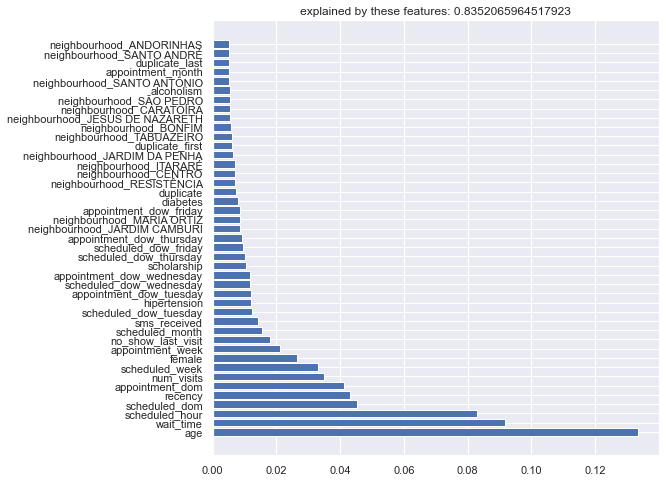

In [424]:
feature_importance_plot(f_imp, cutoff = 0.005, figsize = (8,8))

> As usual continuous variables (`age` and `wait_time`) are on top here. We see that mainly the neightborhoods seem less important, so let's see how we perform when we remove this.

We store models in the `models` folder so we don't need to retrain. Test AUC included in the name.

In [625]:
# store model - test accuracy in filename
dump(clf, 'models/rf_base_05636.joblib') 

['models/rf_base_05636.joblib']

#### 3.4 reduced features
We'll take out the neighbourhood parameters as they've shown to be of little importance.

In [626]:
# train
reduced_features = [f for f in features if f[:3] != 'nei']
clf_red = RandomForestClassifier()
clf_red.fit(X_train[reduced_features], np.ravel(y_train)) #ravel supresses warning but has no real effect...

RandomForestClassifier()

In [627]:
clf_red.score(X_train[reduced_features], y_train)

0.9958812726192405

In [631]:
red = analyse_result([clf_red, X_test[reduced_features]], y_test, model = 'reduced_model')
pd.concat([base,red], axis = 1)

,base_model,reduced_model
accuracy,0.808494,0.792153
recall,0.156469,0.189330
precision,0.572435,0.449706
specificity,0.970891,0.942296
f1-score,0.245762,0.266473
AUC score,0.563680,0.565813


In [629]:
y_pred = clf_red.predict(X_test[reduced_features])
confusion_matrix(y_test, y_pred)

array([[27516,  1685],
       [ 5896,  1377]])

> Minor drop in accuracy, but a recall improvement (overall f1-score and AUC-score improvement): removing the neightbourhoods does not hurt the performance of our model

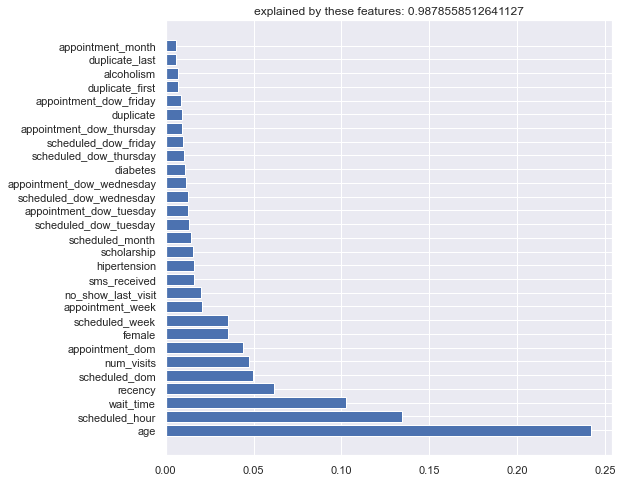

In [632]:
f_imp = feature_importance(X_train[reduced_features], clf_red)
feature_importance_plot(f_imp, cutoff = 0.005, figsize = (8,8))

> Note: the main difference in feature importance is the drop for 'scheduled_dom'.

In [633]:
# store model - test accuracy in filename
dump(clf_red, 'models/rf_red_05658.joblib') 

['models/rf_red_05658.joblib']

## 4. Parameter tuning
***
We're a good way up with 80% accuracy, but, we've also seen some issues:
* Firstly, we are overfitting our model (train_acc ~ 1 >> test_acc) 
* Our model has a very poor recall (and hence f1-score), caused by the imbalance in our classes.

We can run some quick GridSeaches to try to optimise our hyperparamaters.
* Random Hyperparameter Search on a wide grid of hyperparameters
* Grid Search, using a narrow range around the hyperparameters found via the Random Search

*Note: from experience, the Cross Validation in these grid-searches often helps with overfitting.*

#### 4.1 Randomised Grid Search (hyperparamter tuning)
We run the random grid search for the parameters that are know to be the most important for Random Forests. 

A specific addition that is not one of the most common hyperparameters to tune is the `class_weight`. We'll try some variations for this parameters as well since we've seen a negative impact from the class imbalance (20% no_shows).


In [634]:
# what can we use for scoring!?
sorted(SCORERS.keys())[:5]

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy']

We've also seen that our AUC and F1 score are very low, meaning we do not capture the patterns in our data properly. Focussing on accuracy alone here is not optimal; for example: if we always predict '0' for no_show (naive), we would also get 80% accuracy. Our approach to tackle this is to use another metric for scoring in our grid-search. We'll try 'F1' and 'AUC'.

> Note: this has been done on separate iterations on the cell below. We found 'F1' score to work best, actually optimised AUC better as well.

In [635]:
# parameters to check
param_grid = {
    'bootstrap': [True],
    'max_depth': [90, 100, 110, 120, None],
    'max_features': [3, 5, 10],
    'min_samples_leaf': [5, 10, 15],
    'min_samples_split': [3, 5, 8, 10],
    'n_estimators': [500, 600, 700, 800, 1000],
    'class_weight' : ['balanced', 'balanced_subsample', {0:1, 1:2}, {0:1, 1:3}]}

# Create a based model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search_random = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, 
                                   n_iter = 100, cv = 3, verbose=2, random_state=42, 
                                   n_jobs = -1, scoring = 'f1')

In [636]:
# switch to ensure we don't run this every time
random_search = False
if random_search:
    print('started search at: ' + datetime.now().strftime("%H:%M:%S"))
    grid_search_random.fit(X_train[reduced_features], np.ravel(y_train))


In [637]:
if random_search:
    print(grid_search_random.best_params_)

#### 4.2 Run Random optimised parameters
***

In [638]:
# train
clf_rnd = RandomForestClassifier(n_estimators = 500,
                                 min_samples_split = 8,
                                 min_samples_leaf = 10,
                                 max_features = 5,
                                 max_depth = 100,
                                 bootstrap = True, 
                                 class_weight = 'balanced')
clf_rnd.fit(X_train[reduced_features], np.ravel(y_train))

RandomForestClassifier(class_weight='balanced', max_depth=100, max_features=5,
                       min_samples_leaf=10, min_samples_split=8,
                       n_estimators=500)

In [639]:
clf_rnd.score(X_train[reduced_features], y_train)

0.7279479284826879

In [640]:
clf_rnd.score(X_test[reduced_features], y_test)

0.674124033558151

In [641]:
rnd = analyse_result([clf_rnd, X_test[reduced_features]], y_test, model = 'random_optimised_model')
pd.concat([base, red, rnd], axis = 1)

,base_model,reduced_model,random_optimised_model
accuracy,0.808494,0.792153,0.674124
recall,0.156469,0.189330,0.718548
precision,0.572435,0.449706,0.346897
specificity,0.970891,0.942296,0.663059
f1-score,0.245762,0.266473,0.467902
AUC score,0.563680,0.565813,0.690804


> okay, so our accuracy has dropped to a still respectable 67%, but our AUC is up to 69% and f1-score is at 47% (recall at 72%). That shows some good progress!

> also note how we've substantially reduced overfitting!

In [643]:
f_imp = feature_importance(X_train[reduced_features], clf_rnd)
f_imp.head()

,feature,importance
0,wait_time,0.266649
1,age,0.107534
2,scheduled_week,0.0703675
3,scheduled_hour,0.0585386
4,scheduled_dom,0.0547933


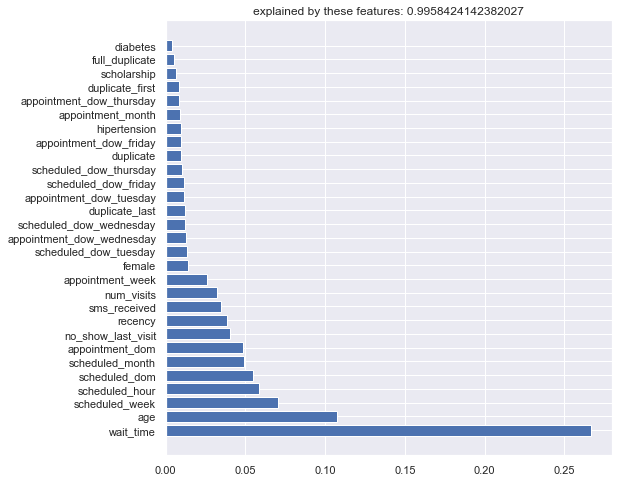

In [644]:
feature_importance_plot(f_imp, cutoff = 0.002, figsize = (8,8))

> Very interesting to see here is that in our new model, the `wait_time` has jumped up and surpassed `age` as most important feature.

> Looking at the ROC curves for both the reduced and optimised plots, we can clearly see our improvement.

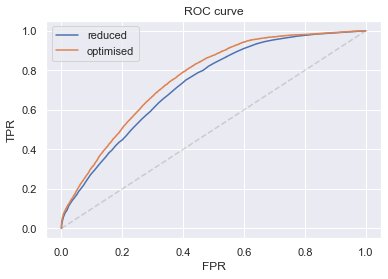

In [646]:
# note: we cannot include our earlier model as it has more features
roc_curve_plot([clf_red, clf_rnd], X_test[reduced_features], y_test, ['reduced','optimised'])

> **NB: We expect the reduced model to be substantially closer to the dashed line (naive). Double check!**

In [652]:
# store model - test accuracy in filename
dump(clf_rnd, 'models/rf_rnd_069.joblib') 

['models/rf_rnd_069.joblib']

#### 4.3 Model Size (Trees)
Larger models (more trees) perform better, but at the cost of increased processing time. Taking our current best parameters, we take a closer look at this behavior and try to find an optimal parameter for estimators (number of trees)- taking into account that processing time increases with this parameters.

> Note: we will use this model intensively for Partial Dependence Plots, hence a smaller model would benefit us. 

In [578]:
estimators = [5, 10, 20, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
f1 = []
auc = []
acc = []

for est in estimators:
    clf_tmp = RandomForestClassifier(n_estimators = est,
                                     min_samples_split = 8,
                                     min_samples_leaf = 10,
                                     max_features = 5,
                                     max_depth = 100,
                                     bootstrap = True, 
                                     class_weight = 'balanced')
    # result
    clf_tmp.fit(X_train[reduced_features], np.ravel(y_train))
    y_pred = clf_tmp.predict(X_test[reduced_features])
    
    # calculate and store metrics
    f1.append(f1_score(y_test, y_pred))
    auc.append(roc_auc_score(y_test, y_pred))
    acc.append(accuracy_score(y_test, y_pred))

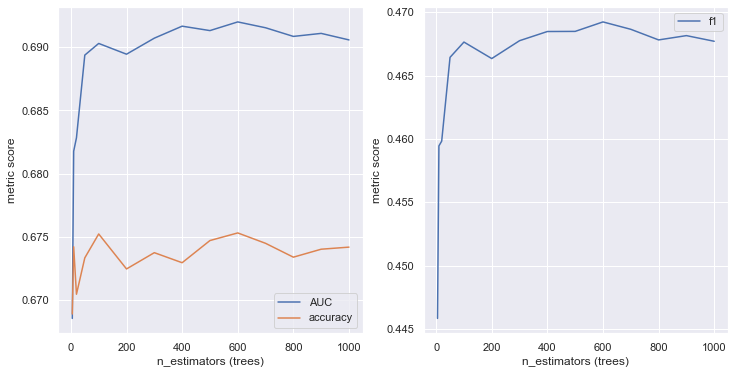

In [580]:
# plot the result
fig, ax = plt.subplots(1,2, figsize = (12,6))
ax[0].plot(estimators, auc, label = 'AUC')
ax[0].plot(estimators, acc, label = 'accuracy')
ax[0].legend()
ax[0].set_xlabel('n_estimators (trees)')
ax[0].set_ylabel('metric score')

ax[1].plot(estimators, f1, label = 'f1')
ax[1].legend()
ax[1].set_xlabel('n_estimators (trees)')
ax[1].set_ylabel('metric score');

> We can see a clear maximum at for 600 estimators (trees). However, this is not that much better than 100 trees, where we find a local maximum. Let's see if we can optimise against the latter.

#### 4.4 Grid Search on a narrower range
We take the optimal parameters from the Random Search, and the `n_estimators` parameters determined at 100 above and perform the final Grid Search.

Finally, we triend some manual variations. 

In [596]:
# parameter grid based on random search & fix n_estimators from above
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 95],
    'max_features': [3, 4, 5, 6, 7],
    'min_samples_leaf': [8, 9, 10, 11, 12],
    'min_samples_split': [8, 9, 10, 11 , 12],
    'n_estimators': [100],
    'class_weight' : ['balanced']}

# Create a based model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search_cv = GridSearchCV(estimator = rf, param_grid = param_grid, 
                              cv = 3, n_jobs = -1, verbose = 2) #, scoring = 'f1')


In [606]:
# switch to ensure we don't run this every time
grid_search = False
if grid_search:
    print('started search at: ' + datetime.now().strftime("%H:%M:%S"))
    grid_search_cv.fit(X_train[reduced_features], np.ravel(y_train))


In [607]:
if grid_search:
    print(grid_search_cv.best_params_)

#### 4.5 Run optimised Model

In [647]:
# train
clf_opt = RandomForestClassifier(n_estimators = 100,
                                 min_samples_split = 10,
                                 min_samples_leaf = 8,
                                 max_features = 7,
                                 max_depth = 95,
                                 bootstrap = True, 
                                 class_weight = 'balanced_subsample') 
clf_opt.fit(X_train[reduced_features], np.ravel(y_train))

RandomForestClassifier(class_weight='balanced_subsample', max_depth=95,
                       max_features=7, min_samples_leaf=8,
                       min_samples_split=10)

In [648]:
clf_opt.score(X_train[reduced_features], y_train)

0.7833279317236537

In [649]:
clf_opt.score(X_test[reduced_features], y_test)

0.6994023139770795

In [650]:
opt = analyse_result([clf_opt, X_test[reduced_features]], y_test, model = 'grid_optimised_model')
pd.concat([base, red, rnd, opt], axis = 1)

,base_model,reduced_model,random_optimised_model,grid_optimised_model
accuracy,0.808494,0.792153,0.674124,0.699402
recall,0.156469,0.189330,0.718548,0.651451
precision,0.572435,0.449706,0.346897,0.359839
specificity,0.970891,0.942296,0.663059,0.711346
f1-score,0.245762,0.266473,0.467902,0.463601
AUC score,0.563680,0.565813,0.690804,0.681398


In [651]:
y_pred = clf_opt.predict(X_test[reduced_features])
confusion_matrix(y_test, y_pred)

array([[20772,  8429],
       [ 2535,  4738]])

> We've balanced back to accuracy a bit and see AUC score deteriorate a bit as well. Also, the difference between the train and test_accuracy is back a bit (likely due to the smaller number of trees).

In [653]:
# store model - test accuracy in filename
dump(clf_opt, 'models/rf_opt_06814.joblib') 

['models/rf_opt_06814.joblib']

## 5. conclusion
***

#### 5.1 store data
We've stored our models for easy use next time - and in another notebook. Let's also store our pre-processed dataframe, ready to use for this model.

In [654]:
# store the input data for the model
filename = 'data/no_shows_model.h5'
df_out = pd.concat([df[reduced_features], df[target]], axis = 1)
df_out.to_hdf(filename, key = 'no_shows', format = 'table')

In [655]:
# check the file
df_check = pd.read_hdf(filename)
print(df_check.shape)

(110526, 39)


#### 5.2 notes
We've ended up with a model with an AUC of 68% which seems to capture the patterns in our data well. Accuracy is at 70%, which is good, as wel optimised more for AUC, allowing the patterns to be captured better for the Partial Dependence plots in the next phase.

We're confident in the feature's we've generated during the EDA and can even see the result as the wait-time came out as most important feature.

It would be interesting to try this procedure with XGBoost as well, and to look closer at other optimisations (i.e. what if we fully optimise on accuracy) in a later stage.